Tutorial 2. Implementation of the classical MNIST FC classifier
==================================================

This is the second tutorial of the neural wrappers library which focuses on creating a more complicated neural network as well as using the h5py library for loading data from the disk rather than having it all on memory. It builds upon the knowledge of the previous tutorial.

Mirror on GitHub: https://gist.github.com/Meehai/85429f878e319a70116a9d72aaf83ac1

##### 1. H5py datasets

Most of the times when working with large datasets, we need to load them on-the-fly, for each iteration. We could use some data-specific loaders (i.e. read each image when needed, or each audio file, each dataframe row etc.), transform the data into arrays and then feed it to the model's `train_generator` method using the `DatasetReader` class or simply creating a generator manually.

However, at least for not very very large images/videos, I prefered to use H5 binary files, which already converts the data into NumPy-like arrays. A h5 file can be though of as a dictionary, that has some keys and some values. The values can also be dictionaries or just values/arrays.

For our MNIST dataset (60000 items), the layout will be something like this:

    "train"
        "images" :: uint8 : (50000, 28, 28),
        "labels" :: uint8 : (50000, )
    "test"
        "images" :: uint8 : (10000, 28, 28),
        "labels" :: uint8 : (10000, )

The `reader_converts` directory in the root of the project has some basic converters (not really updated recently), including the raw MNIST to h5 dataset one. The `MNISTReader` class assumes that this convention is met, expecting a h5 dataset in the path. Images are converted by default to float32 and labels are one-hotted to 10 classes using the `dimTransform` constructor attribute that is defined in `DatasetReader`. This is one way of transforming our data according to some function. We could also update it manually in `iterate_once` before yield-ing the batch.

I suggest not skipping the next step until it works as in the tutorial.

In [1]:
import numpy as np
from neural_wrappers.readers import MNISTReader
from neural_wrappers.utilities import getGenerators, toCategorical

reader = MNISTReader("/home/mihai/Public/Datasets/mnist/mnist.h5", 
    dimTransform = {
        "images" : lambda x : np.float32(x) / 255,
        "labels" : lambda x : toCategorical(x, numClasses=10)
    })
print(reader.summary())

trainGenerator, trainSteps, testGenerator, testSteps = getGenerators(reader, miniBatchSize=20, keys=["train", "test"])
print("Train steps:", trainSteps, "Test steps:", testSteps)

[MNIST Reader] Setup complete
[Dataset summary]
General dataset reader. Update __str__ in your dataset for more details when using summary.
All dims: {'labels', 'images'}. Data dims: ['images']. Label dims: ['labels']
Dim transforms: {'labels': <function <lambda> at 0x7ffad0051b90>, 'images': <function <lambda> at 0x7ffad0e5a8c0>}
Normalizers: {'labels': 'identity', 'images': 'identity'}

Train steps: 3000 Test steps: 500


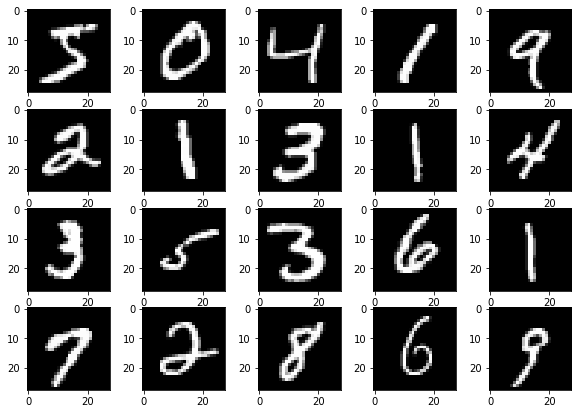

Images: (20, 28, 28, 1) float32
One-hotted labels: (20, 10) uint8


In [2]:
import matplotlib.pyplot as plt
%matplotlib inline 

fig, ax = plt.subplots(4, 5)
fig.set_size_inches(10, 7)
data, labels = next(trainGenerator)
for i in range(20):
    # MBx28x28x1 => 28x28
    image = data[i, :, :, 0]
    ax[i // 5][i % 5].imshow(image, cmap="gray")
plt.show()
    
print("Images:", data.shape, data.dtype)
print("One-hotted labels:", labels.shape, labels.dtype)

##### 2. Defining the network

This is more or less identical to the first tutorial, just that we use a bigger model including some convolutions as well.

In [3]:
from neural_wrappers.pytorch import NeuralNetworkPyTorch
import torch as tr
import torch.nn as nn
import torch.nn.functional as F

class Model(NeuralNetworkPyTorch):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=10, kernel_size=3)
        self.conv2 = nn.Conv2d(in_channels=10, out_channels=20, kernel_size=3)
        self.fc3 = nn.Linear(in_features=24 * 24 * 20, out_features=100)
        self.fc4 = nn.Linear(in_features=100, out_features=10)
        
    def forward(self, x):
        # MBx28x28x1 => MBx1x28x28
        x = x.permute(0, 3, 1, 2)
        # MBx1x28x28 => MBx10x26x26
        y1 = F.relu(self.conv1(x))
        # MBx10x26x26 => MBx20x24x24
        y2 = F.relu(self.conv2(y1))
        # MBx20x24x24 => MBx(20*24*24)
        y2 = y2.view(y2.shape[0], -1)
        # MBx(20*24*24) => MBx100
        y3 = F.relu(self.fc3(y2))
        # MBx100 => MBx10
        y4 = self.fc4(y3)
        return y4

# Testing the model
model = Model()
print(model.npForward(np.random.randn(14, 28, 28, 1).astype(np.float32)).shape)

(14, 10)


##### 3. Training the network

This step is mostly identical to how we trained the network in the first tutorial, we define an optimizer, and a loss function, add some metrics and callbacks and call the `train_generator` method.

Epoch 1/10. Done: 10.00%. LR: 0.01000. Took: 0:01:08.935342.  - Metrics. [Train] Accuracy: 89.830. Loss: 0.332. | [Validation] Val Accuracy: 95.180. Val Loss: 0.156.
[SaveModels] Epoch 1. Improvement (Loss) from nan to 0.16
Epoch 2/10. Done: 20.00%. LR: 0.01000. Took: 0:01:11.542383.  - Metrics. [Train] Accuracy: 96.662. Loss: 0.111. | [Validation] Val Accuracy: 97.120. Val Loss: 0.094.
[SaveModels] Epoch 2. Improvement (Loss) from 0.16 to 0.09
Epoch 3/10. Done: 30.00%. LR: 0.01000. Took: 0:01:05.493663.  - Metrics. [Train] Accuracy: 97.687. Loss: 0.076. | [Validation] Val Accuracy: 97.730. Val Loss: 0.073.
[SaveModels] Epoch 3. Improvement (Loss) from 0.09 to 0.07
Epoch 4/10. Done: 40.00%. LR: 0.01000. Took: 0:01:12.047450.  - Metrics. [Train] Accuracy: 98.345. Loss: 0.055. | [Validation] Val Accuracy: 98.000. Val Loss: 0.065.
[SaveModels] Epoch 4. Improvement (Loss) from 0.07 to 0.06
Epoch 5/10. Done: 50.00%. LR: 0.01000. Took: 0:01:09.958186.  - Metrics. [Train] Accuracy: 98.773. Lo

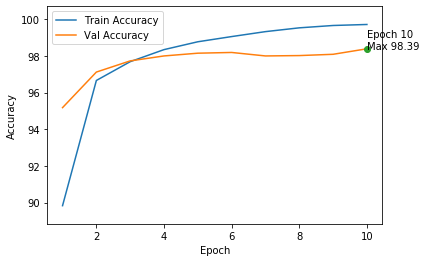

In [4]:
import torch.optim as optim
import torch.nn.functional as F
from neural_wrappers.callbacks import SaveModels, PlotMetrics, ConfusionMatrix
from neural_wrappers.metrics import Accuracy

def lossFn(y, t):
    # Negative log-likeklihood (used for softmax+NLL for classification), expecting targets are one-hot encoded
    y = F.softmax(y, dim=1)
    t = t.type(tr.bool)
    return (-tr.log(y[t] + 1e-5)).mean()

trainGenerator, trainSteps, testGenerator, testSteps = getGenerators(reader, miniBatchSize=20, keys=["train", "test"])
model = Model()

model.setCriterion(lossFn)
model.setOptimizer(optim.SGD, lr=0.01, momentum=0.5)
model.addCallbacks([SaveModels("best"), PlotMetrics(["Loss", "Accuracy"], ["min", "max"])])
model.addMetrics({"Accuracy" : Accuracy()})
model.train_generator(trainGenerator, trainSteps, 10, testGenerator, testSteps, printMessage="v1")

##### 4. Defining a new test callbacks

We'd sometimes like to create new callbacks that can be used during training or testing. To do this, we create new classes that extend `Callback` and define one (or more) of the four methods `onIterationStart`, `onIterationEnd`, `onEpochStart`, `onEpochEnd`. Each of these have access to the model's reference as well as other information.

For example, we'll just take a few batches of the test set and plot the results with the predicted class probability as well as label.

In [5]:
from neural_wrappers.callbacks import Callback

model = Model()
model.addMetrics({"Accuracy" : Accuracy()})
model.setCriterion(lossFn)
model.loadModel("model_best_Loss.pkl")
results = model.test_generator(testGenerator, testSteps)
print("Results")
for k in results:
    print("  - %s : %s" % (k, results[k]))

Loading model from model_best_Loss.pkl
Succesfully loaded weights (1155030 parameters) 
Succesfully loaded optimizer: SGD. Learning rate: 0.01, Momentum: 0.5, Dampening: 0, Weight Decay: 0, Nesterov: False
Succesfully loaded model history (epoch 5)
Succesfully loaded 4 callbacks (2 metrics)
Finished loading model
Results
  - Loss : 0.06166076519836741
  - <neural_wrappers.callbacks.save_models.SaveModels object at 0x7ffabc6d9790> : 0.0
  - <neural_wrappers.callbacks.plot_metrics.PlotMetrics object at 0x7ffabc887fd0> : 0.0
  - Accuracy : 98.14999803700005


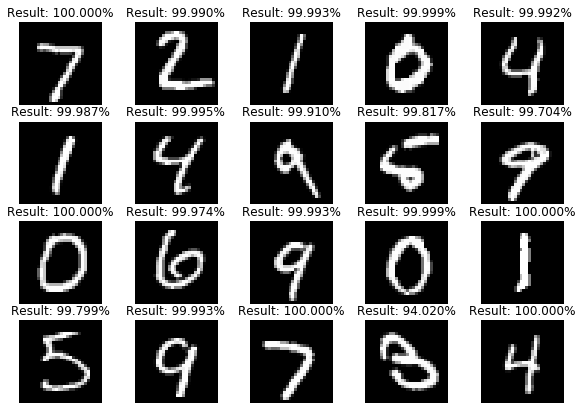

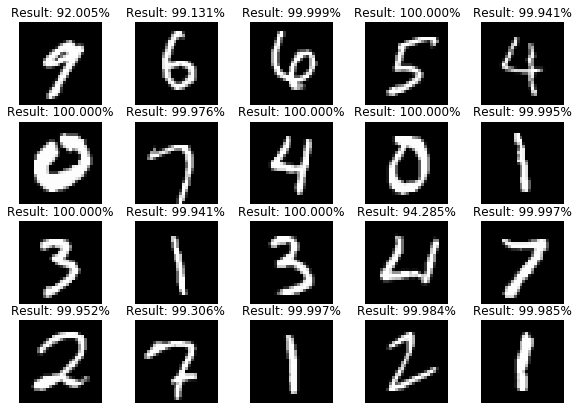

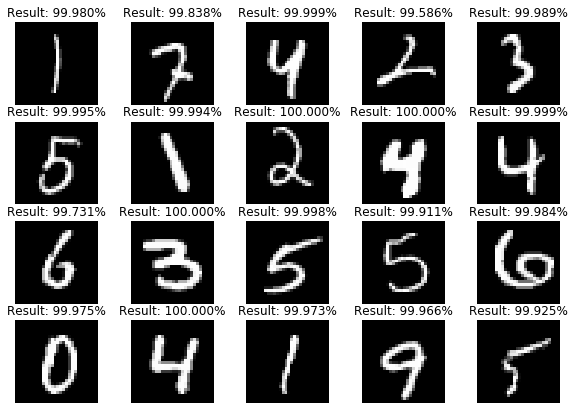

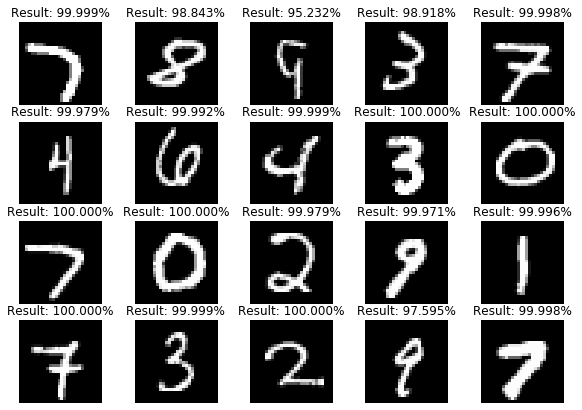

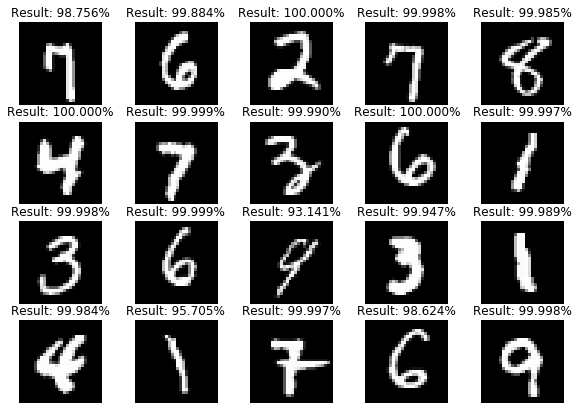

In [6]:
class MyCallback(Callback):
    def __init__(self, gridShape):
        super().__init__()
        self.gridShape = gridShape

    def onIterationEnd(self, results, labels, **kwargs):
        data = kwargs["data"]

        fig, ax = plt.subplots(nrows=self.gridShape[0], ncols=self.gridShape[1])
        [axi.set_axis_off() for axi in ax.ravel()]
        fig.set_size_inches(10, 7)
        for i in range(data.shape[0]):
            image = data[i, :, :, 0]
            labelIx = np.argmax(labels[i])
            P = np.exp(results[i])/sum(np.exp(results[i]))
            title = "Result: %2.3f%%" % (P[labelIx] * 100)
            ax[i // self.gridShape[1]][i % self.gridShape[1]].imshow(image, cmap="gray")
            ax[i // self.gridShape[1]][i % self.gridShape[1]].set_title(title)            

model.addCallbacks([MyCallback(gridShape=(4, 5))])
_ = model.test_generator(testGenerator, 5)

##### 4. Final thoughts

This is a rought example on how to train a model using h5py library and predefined reader. I suggest seeing examples/mnist-classifier/main.py for a way to organize the project for command line, using `ArgumentParser`, as well as seeing how training/retraining (strating from a checkpoint and continuing from there w/o altering results) can be achieved.